## Reconocimiento de Animales

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from keras import regularizers
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from keras import backend
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.models import load_model
import itertools

In [2]:
print(tf.__version__)

2.10.1


In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
path = 'D:/datasets/ANIMALES RED/'

In [5]:
data = {"imgpath": [] , "labels": [] }

In [6]:
category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
      

df = pd.DataFrame(data) 

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

In [7]:
## Dataset
df.sample(n=10, random_state=1)

,imgpath,labels,encoded_labels
4739,D:/datasets/ANIMALES RED/mucca\OIP-GdxI-WFmFt9...,mucca,2
5605,D:/datasets/ANIMALES RED/mucca\OIP-vKiBGH0ARNI...,mucca,2
5495,D:/datasets/ANIMALES RED/mucca\OIP-TiiKQwMuSMj...,mucca,2
4205,D:/datasets/ANIMALES RED/mucca\OIP-5HZ3RpK3kS_...,mucca,2
3228,D:/datasets/ANIMALES RED/gatto\468.jpeg,gatto,1
2745,D:/datasets/ANIMALES RED/gatto\1552.jpeg,gatto,1
3611,D:/datasets/ANIMALES RED/gatto\ea30b0062af21c2...,gatto,1
3491,D:/datasets/ANIMALES RED/gatto\896.jpeg,gatto,1
1185,D:/datasets/ANIMALES RED/cane\OIP-skAoh56HSQvD...,cane,0
74,D:/datasets/ANIMALES RED/cane\OIP-LgbZBRDDbmMm...,cane,0


In [8]:
print("Shape of the dataset: ", df.shape)
print("_______________________________________")
print("Number of null values: ")
print(df.isnull().sum())
print("_______________________________________")
print("Number of unique values: ")
print(df.nunique())

print("---------------------------------------")
print("Number of images per category : ")
print(df.labels.value_counts()) 

Shape of the dataset:  (7997, 3)
_______________________________________
Number of null values: 
imgpath           0
labels            0
encoded_labels    0
dtype: int64
_______________________________________
Number of unique values: 
imgpath           7997
labels               4
encoded_labels       4
dtype: int64
---------------------------------------
Number of images per category : 
labels
cane     2347
ragno    2116
mucca    1866
gatto    1668
Name: count, dtype: int64


### Test y Entrenamiento

In [9]:
train_df, Temp_df = train_test_split(df,  train_size= 0.75 , shuffle=True, random_state=23)
valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.6 , shuffle=True, random_state=23)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [10]:
print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath labels
0  D:/datasets/ANIMALES RED/cane\OIP-Y6B78QaOUn4q...   cane
1  D:/datasets/ANIMALES RED/ragno\OIP-TucUistkkPW...  ragno
2  D:/datasets/ANIMALES RED/ragno\OIP-Uk9jVHuzqKq...  ragno
3  D:/datasets/ANIMALES RED/mucca\OIP-vSpxIjbOOji...  mucca
4           D:/datasets/ANIMALES RED/gatto\1477.jpeg  gatto
(5997, 3)
--------Validation----------
                                             imgpath labels
0  D:/datasets/ANIMALES RED/ragno\OIP-wcYX17cyRNv...  ragno
1  D:/datasets/ANIMALES RED/ragno\OIP-szmk-9ImYlZ...  ragno
2  D:/datasets/ANIMALES RED/ragno\OIP-rX9_RRCh7Te...  ragno
3  D:/datasets/ANIMALES RED/ragno\OIP-MM41xzjWNxV...  ragno
4  D:/datasets/ANIMALES RED/ragno\OIP-olemVESRVfB...  ragno
(1200, 3)
----------Test--------------
                                             imgpath labels
0  D:/datasets/ANIMALES RED/ragno\OIP-uas3AwpS29H...  ragno
1            D:/datasets/ANIMALES RED/gatto\301.jpeg 

Text(0.5, 1.0, 'Distribución de Clases')

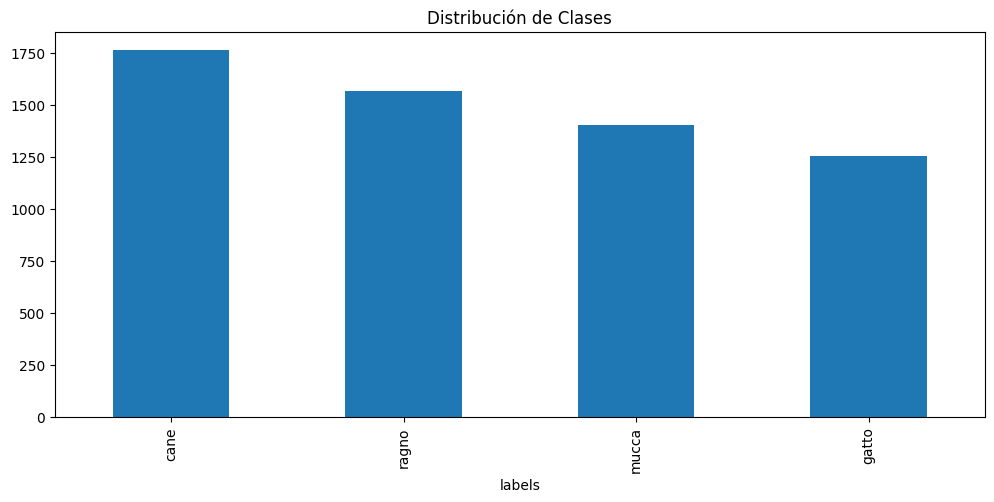

In [11]:
# Visualización de las distribuciones de clases en el conjunto de entrenamiento y prueba
plt.figure(figsize=(12, 5))
train_df['labels'].value_counts().transpose().plot(kind='bar')
plt.title('Distribución de Clases')

Text(0.5, 1.0, 'Distribución de Clases - Conjunto de Test')

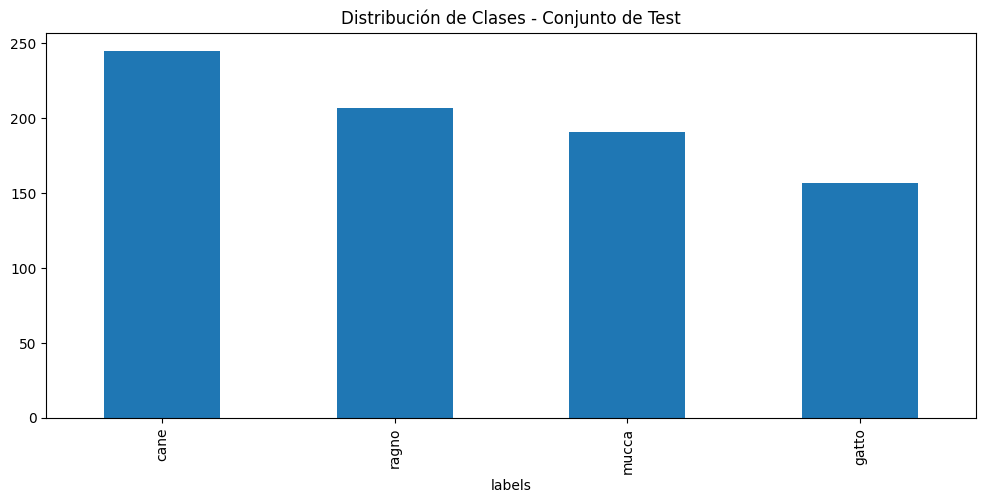

In [12]:
# Visualización de las distribuciones de clases en el conjunto de entrenamiento y prueba
plt.figure(figsize=(12, 5))
test_df['labels'].value_counts().transpose().plot(kind='bar')
plt.title('Distribución de Clases - Conjunto de Test')

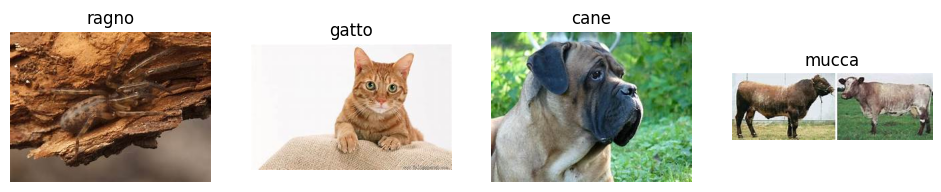

In [13]:
plt.figure(figsize=(15,12))
for i, label in enumerate(valid_df['labels'].unique()):
    # Selecciona una fila aleatoria con la etiqueta actual
    row = df[df['labels'] == label].sample(n=1).iloc[0]
    
    # Carga la imagen y la muestra
    image_path = row['imgpath']
    image = Image.open(image_path)
    
    # Configura la subfigura actual
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

### Creating Dataloaders

In [14]:
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)

generador = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

training_set = generador.flow_from_dataframe(dataframe=train_df,
                                                x_col='imgpath',
                                                y_col='labels',
                                                batch_size=BATCH_SIZE,
                                                target_size=IMAGE_SIZE,
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

validation_set = generador.flow_from_dataframe(dataframe=valid_df,
                                                x_col='imgpath',
                                                y_col='labels',
                                                batch_size=BATCH_SIZE,
                                                target_size=IMAGE_SIZE,
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')


test_set = generador.flow_from_dataframe(dataframe=test_df,
                                                x_col='imgpath',
                                                y_col='labels',
                                                batch_size=BATCH_SIZE,
                                                target_size=IMAGE_SIZE,
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 5997 validated image filenames belonging to 4 classes.
Found 1200 validated image filenames belonging to 4 classes.
Found 800 validated image filenames belonging to 4 classes.


In [15]:
training_set.class_indices

{'cane': 0, 'gatto': 1, 'mucca': 2, 'ragno': 3}

### Arquitectura


In [16]:
weight_decay = 1e-4

num_classes = 4

model = tf.keras.models.Sequential()

model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(128, 128, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation="linear"))
model.add(Activation('elu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1088      
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      65600     
                                                                 
 activation_1 (Activation)   (None, 128, 128, 64)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                        

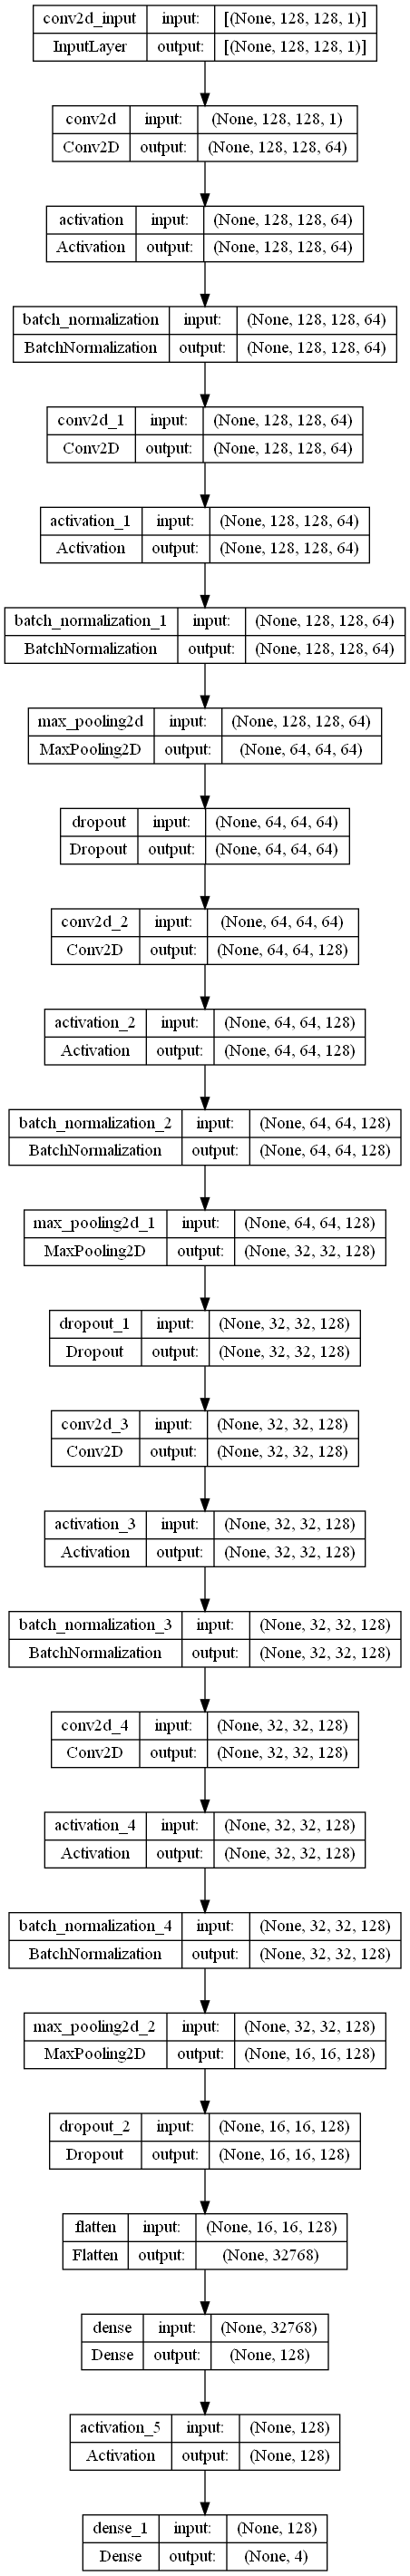

In [18]:
plot_model(model, to_file='model_cnn.png', show_shapes=True, show_layer_names=True)

In [19]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 6),
                ModelCheckpoint(
                    filepath='model.weights.best.hdf5',
                    monitor="val_accuracy",
                    verbose=1,
                    save_best_only=True,
                    mode="max")]

In [20]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

In [21]:
history = model.fit(x=training_set,
                 validation_data=validation_set,
                 epochs=75,
                 callbacks=[checkpointer],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/75
187/187 [==============================] - ETA: 0s - loss: 2.3050 - accuracy: 0.4069
Epoch 1: val_accuracy improved from -inf to 0.31757, saving model to model.weights.best.hdf5
187/187 [==============================] - 165s 826ms/step - loss: 2.3050 - accuracy: 0.4069 - val_loss: 3.2007 - val_accuracy: 0.3176
Epoch 2/75
187/187 [==============================] - ETA: 0s - loss: 1.1331 - accuracy: 0.5108
Epoch 2: val_accuracy did not improve from 0.31757
187/187 [==============================] - 48s 258ms/step - loss: 1.1331 - accuracy: 0.5108 - val_loss: 1.9649 - val_accuracy: 0.3167
Epoch 3/75
187/187 [==============================] - ETA: 0s - loss: 1.0004 - accuracy: 0.5807
Epoch 3: val_accuracy improved from 0.31757 to 0.45777, saving model to model.weights.best.hdf5
187/187 [==============================] - 50s 267ms/step - loss: 1.0004 - accuracy: 0.5807 - val_loss: 2.0979 - val_accuracy: 0.4578
Epoch 4/75
187/187 [==============================] - ETA: 0s - loss:

Text(0, 0.5, 'Loss')

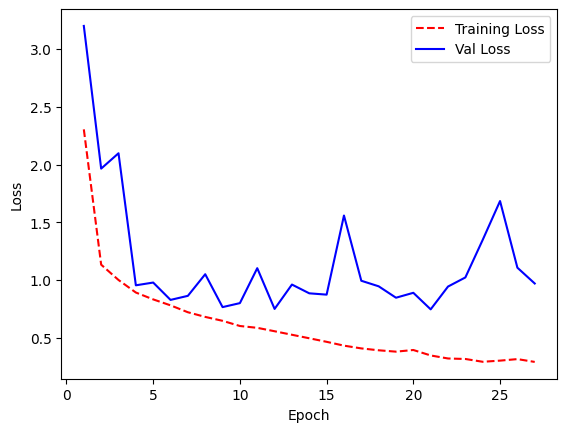

In [22]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.rcParams['figure.figsize'] = [10, 5]
plt.style.use(['default'])
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

(0.2858868524432182, 1.0)

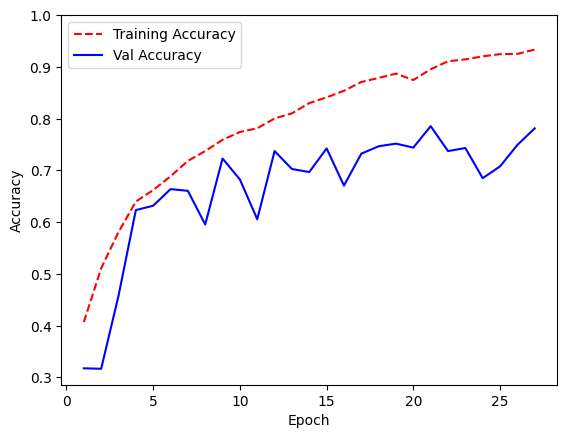

In [23]:
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history

plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top = 1)

In [24]:
model.save("cnn_model.h5")

In [25]:
print(f"Test accuracy = {model.evaluate(test_set ,batch_size=test_set.batch_size,steps=test_set.n // test_set.batch_size)[1]*100}%")

25/25 [==============================] - 37s 2s/step - loss: 0.7320 - accuracy: 0.8012
Test accuracy = 80.12499809265137%


### Matriz de Confusion

In [26]:
model = tf.keras.models.load_model('cnn_model.h5')

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

188/188 [==============================] - 29s 153ms/step
Confusion Matrix
[[565 328 414 459]
 [398 211 332 316]
 [447 254 330 375]
 [510 315 370 373]]
Classification Report
              precision    recall  f1-score   support

        cane       0.29      0.32      0.31      1766
       gatto       0.19      0.17      0.18      1257
       mucca       0.23      0.23      0.23      1406
       ragno       0.24      0.24      0.24      1568

    accuracy                           0.25      5997
   macro avg       0.24      0.24      0.24      5997
weighted avg       0.24      0.25      0.25      5997



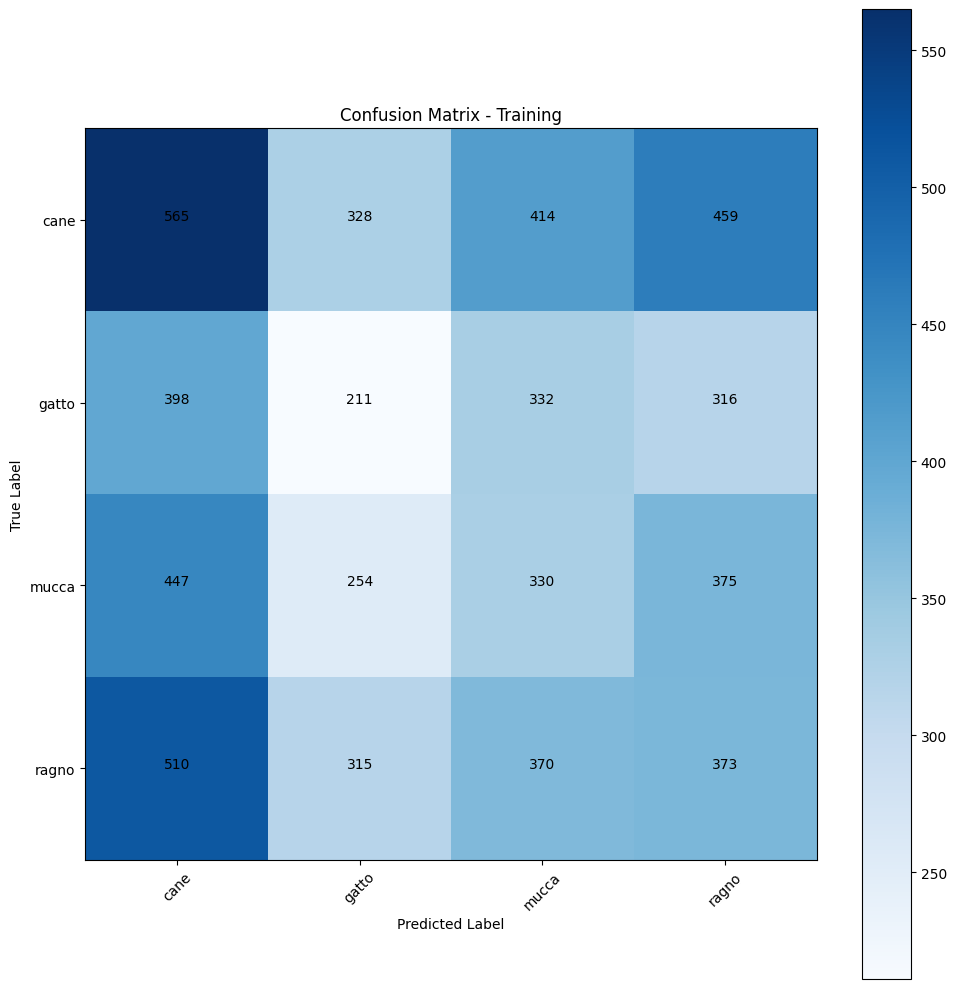

In [28]:
y_pred = model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)

g_dict = training_set.class_indices
classes = list(g_dict.keys())
class_labels = {v:k for k,v in g_dict.items()}

# Confusion matrix
cm = confusion_matrix(training_set.classes, y_pred)

print('Confusion Matrix')
print(cm)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))


plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix - Training')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()



38/38 [==============================] - 5s 136ms/step
Confusion Matrix
[[105  62  87  82]
 [ 75  53  64  62]
 [101  45  55  68]
 [109  54  75 103]]
Classification Report
              precision    recall  f1-score   support

        cane       0.27      0.31      0.29       336
       gatto       0.25      0.21      0.23       254
       mucca       0.20      0.20      0.20       269
       ragno       0.33      0.30      0.31       341

    accuracy                           0.26      1200
   macro avg       0.26      0.26      0.26      1200
weighted avg       0.26      0.26      0.26      1200



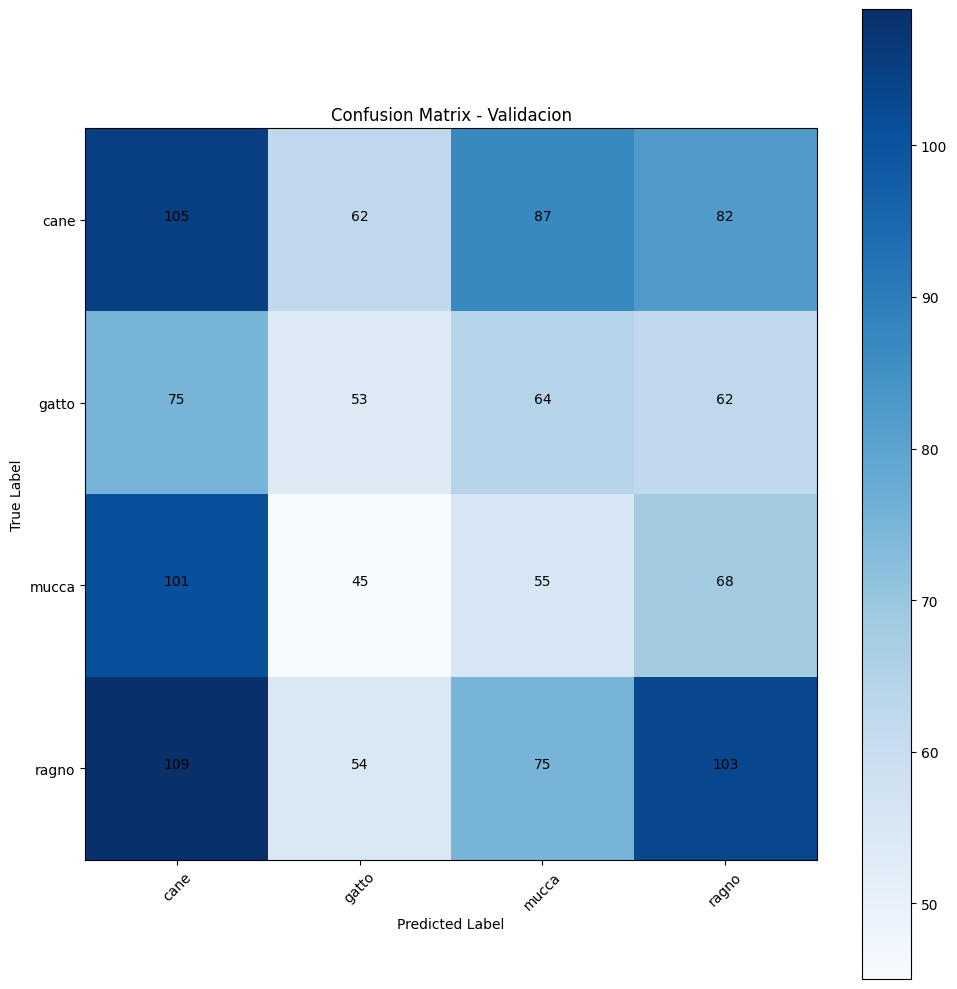

In [29]:
y_pred = model.predict(validation_set)
y_pred = np.argmax(y_pred, axis=1)

g_dict = validation_set.class_indices
classes = list(g_dict.keys())
class_labels = {v:k for k,v in g_dict.items()}

# Confusion matrix
cm = confusion_matrix(validation_set.classes, y_pred)

print('Confusion Matrix')
print(cm)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_set.classes, y_pred, target_names=target_names))

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix - Validacion')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

25/25 [==============================] - 4s 146ms/step
Confusion Matrix
[[84 35 67 59]
 [47 34 41 35]
 [72 24 52 43]
 [67 40 42 58]]
Classification Report
              precision    recall  f1-score   support

        cane       0.31      0.34      0.33       245
       gatto       0.26      0.22      0.23       157
       mucca       0.26      0.27      0.26       191
       ragno       0.30      0.28      0.29       207

    accuracy                           0.28       800
   macro avg       0.28      0.28      0.28       800
weighted avg       0.28      0.28      0.28       800



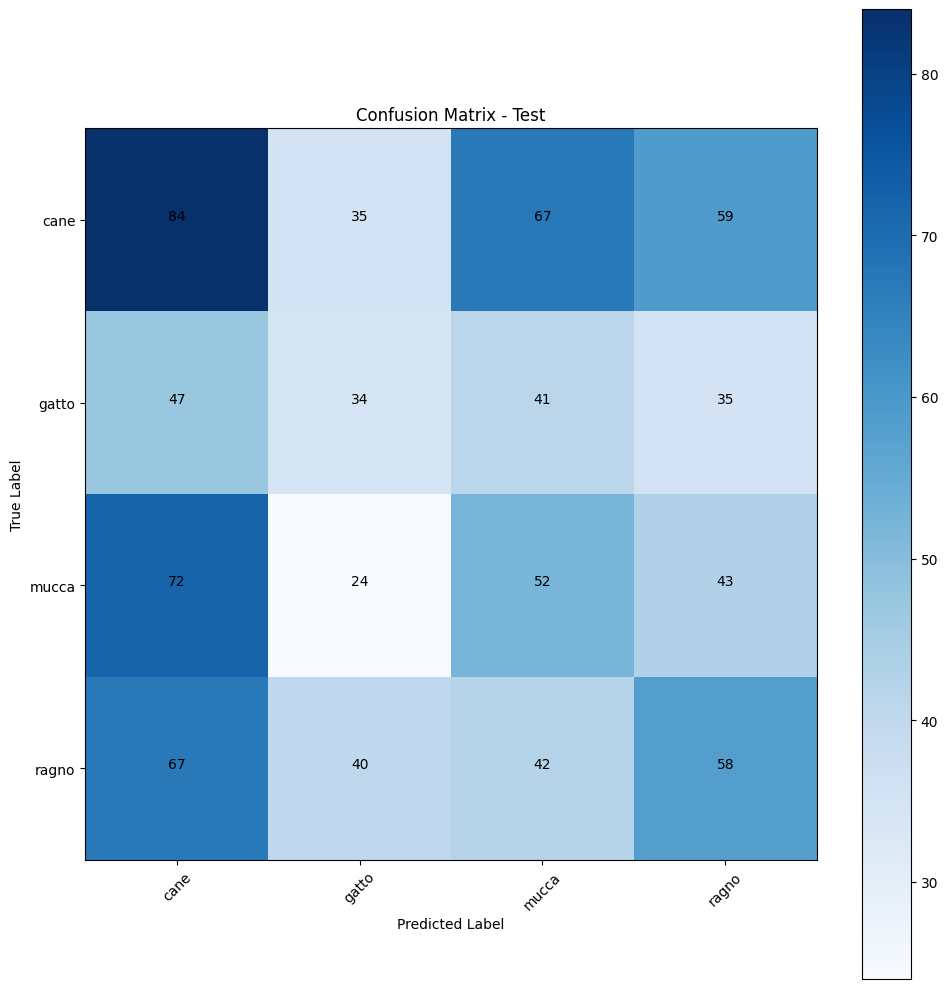

In [30]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

g_dict = test_set.class_indices
classes = list(g_dict.keys())
class_labels = {v:k for k,v in g_dict.items()}


# Confusion matrix
cm = confusion_matrix(test_set.classes, y_pred)

print('Confusion Matrix')
print(cm)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))


plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix - Test')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()



### Predicciones

In [33]:
# next function assigns one batch to variables, i.e x_test,y_test will have 64 images
x_test,y_test = next(test_set)
predict = model.predict(x_test)

1/1 [==============================] - 0s 26ms/step


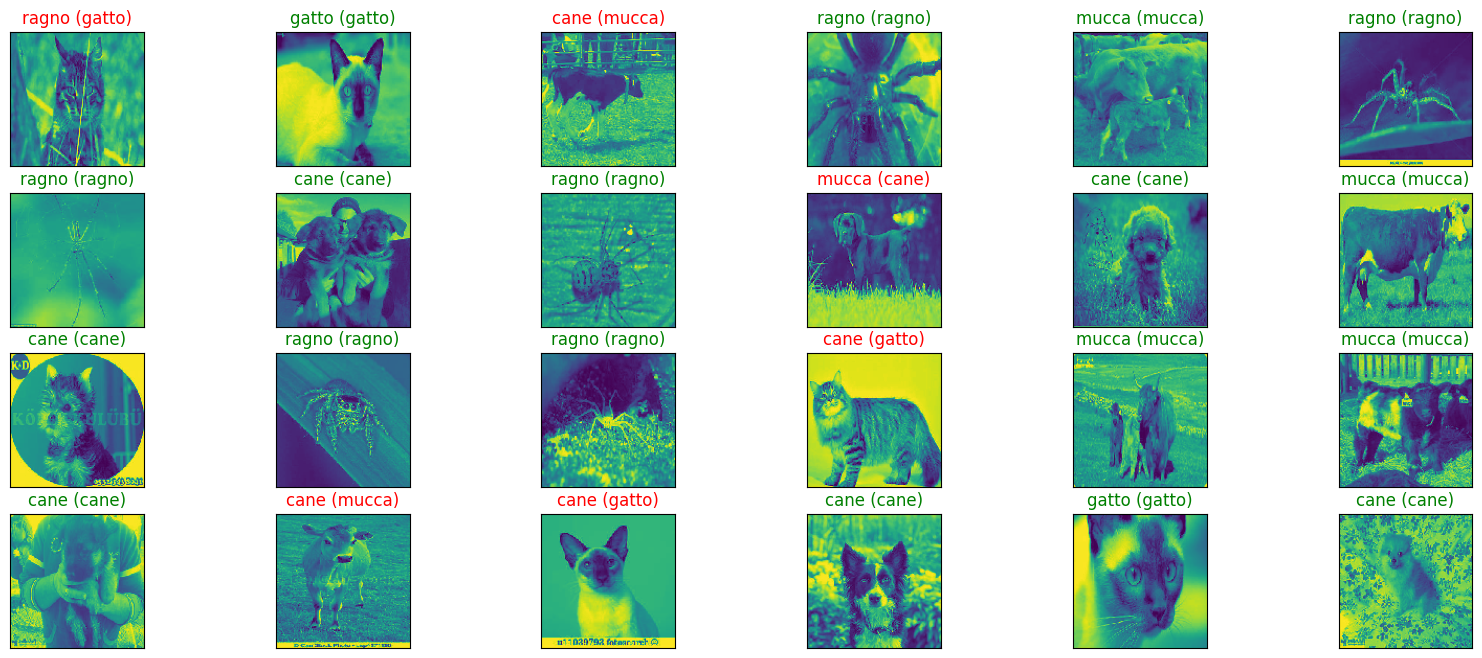

In [35]:
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = class_labels[(np.argmax(predict[index]))]
    true_index = class_labels[(np.argmax(y_test[index]))]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))